<a href="https://colab.research.google.com/github/RealMyeong/Aiffel_Exploration/blob/main/EX_BS2_project8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 프로젝트 : 네이버 영화리뷰 감성분석 도전하기

###  1. 데이터 준비와 확인


- 필요한 모듈 설치

In [ ]:
!pip install konlpy


In [ ]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!pip3 install JPype1-py3

In [ ]:
import os
os.chdir('/tmp/')
!curl -LO https://bitbucket.org/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz
!tar zxfv mecab-0.996-ko-0.9.2.tar.gz
os.chdir('/tmp/mecab-0.996-ko-0.9.2')
!./configure
!make
!make check
!make install

In [ ]:
os.chdir('/tmp')
!curl -LO http://ftpmirror.gnu.org/automake/automake-1.11.tar.gz
!tar -zxvf automake-1.11.tar.gz
os.chdir('/tmp/automake-1.11')
!./configure
!make
!make install

In [ ]:
import os
os.chdir('/tmp')
!curl -LO https://bitbucket.org/eunjeon/mecab-ko-dic/downloads/mecab-ko-dic-2.1.1-20180720.tar.gz
!tar -zxvf mecab-ko-dic-2.1.1-20180720.tar.gz
os.chdir('/tmp/mecab-ko-dic-2.1.1-20180720')
!./autogen.sh
!./configure
!make
# !sh -c 'echo "dicdir=/usr/local/lib/mecab/dic/mecab-ko-dic" > /usr/local/etc/mecabrc'
!make install

In [ ]:
# install mecab-python
import os
os.chdir('/content')

!git clone https://bitbucket.org/eunjeon/mecab-python-0.996.git
os.chdir('/content/mecab-python-0.996')

!python3 setup.py build
!python3 setup.py install

In [ ]:
import pandas as pd
import konlpy
import gensim


In [ ]:
train_data = pd.read_table('/content/drive/MyDrive/AIFFEL/EX/8. 영화리뷰 감상분석/data/ratings_train.txt')
test_data = pd.read_table('/content/drive/MyDrive/AIFFEL/EX/8. 영화리뷰 감상분석/data/ratings_test.txt')

In [ ]:
train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [ ]:
len(train_data), len(test_data)

(150000, 50000)

- 데이터 합치기

In [ ]:
all_data = pd.concat([train_data, test_data], axis = 0, ignore_index = True)

In [ ]:
all_data.tail()

,id,document,label
199995,4608761,오랜만에 평점 로긴했네ㅋㅋ 킹왕짱 쌈뽕한 영화를 만났습니다 강렬하게 육쾌함,1
199996,5308387,의지 박약들이나 하는거다 탈영은 일단 주인공 김대희 닮았고 이등병 찐따 OOOO,0
199997,9072549,그림도 좋고 완성도도 높았지만... 보는 내내 불안하게 만든다,0
199998,5802125,절대 봐서는 안 될 영화.. 재미도 없고 기분만 잡치고.. 한 세트장에서 다 해먹네,0
199999,6070594,마무리는 또 왜이래,0


- 중복치, 결측치 확인 후 제거

In [ ]:
all_data.duplicated().sum()

0

In [ ]:
all_data.isnull().sum()

id          0
document    8
label       0
dtype: int64

In [ ]:
all_data = all_data.dropna(axis=0)

In [ ]:
all_data.isnull().sum()

id          0
document    0
label       0
dtype: int64

In [ ]:
len(all_data)

199992

- 데이터프레임에서 문장이 들어있는 document 부분을 리스트로 바꿔줌

In [ ]:
all_data['document']

0                                       아 더빙.. 진짜 짜증나네요 목소리
1                         흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나
2                                         너무재밓었다그래서보는것을추천한다
3                             교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정
4         사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...
                                ...                        
199995            오랜만에 평점 로긴했네ㅋㅋ 킹왕짱 쌈뽕한 영화를 만났습니다 강렬하게 육쾌함
199996         의지 박약들이나 하는거다 탈영은 일단 주인공 김대희 닮았고 이등병 찐따 OOOO
199997                   그림도 좋고 완성도도 높았지만... 보는 내내 불안하게 만든다
199998       절대 봐서는 안 될 영화.. 재미도 없고 기분만 잡치고.. 한 세트장에서 다 해먹네
199999                                           마무리는 또 왜이래
Name: document, Length: 199992, dtype: object

In [ ]:
sentence_list = list(all_data['document'])

In [ ]:
len(sentence_list)

199992

In [ ]:
from konlpy.tag import Mecab

tokenizer = Mecab()
(tokenizer.morphs(sentence_list[0]))

['아', '더', '빙', '.', '.', '진짜', '짜증', '나', '네요', '목소리']

In [ ]:
all_data = all_data.drop_duplicates('document', keep='first')


###  2. 데이터 로더 구성

  실습 때 다루었던 IMDB 데이터셋은 텍스트를 가공하여 imdb.data_loader() 메서드를 호출하면 숫자 인덱스로 변환된 텍스트와 word_to_index 딕셔너리까지 친절하게 제공합니다. 그러나 이번에 다루게 될 nsmc 데이터셋은 전혀 가공되지 않은 텍스트 파일로 이루어져 있습니다. 이것을 읽어서 imdb.data_loader()와 동일하게 동작하는 자신만의 data_loader를 만들어 보는 것으로 시작합니다. data_loader 안에서는 다음을 수행해야 합니다.

  - 데이터의 중복 제거
  - NaN 결측치 제거
  - 한국어 토크나이저로 토큰화
  - 불용어(Stopwords) 제거
  - 사전 word_to_index 구성
  - 텍스트 스트링을 사전 인덱스 스트링으로 변환
  - X_train, y_train, X_test, y_test, word_to_index 리턴

In [ ]:
from konlpy.tag import Mecab
import numpy as np
from collections import Counter

tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']
def load_data(train_data, test_data, num_words=15000):
  #가공 후에 다시 train, test로 나눠주기 위해 원래 train_data의 크기를 기억
  len_train = len(train_data)
  #train, test 데이터 합쳐줌. 한 번에 가공 하기 위해서
  all_data = pd.concat([train_data, test_data], axis = 0, ignore_index = True) 
  #중복치와 결측치 제거(중복 제거는 'document'부분에서만 실행) 
  all_data = all_data.drop_duplicates('document', keep='first')
  all_data = all_data.dropna(axis=0)
  #후기 문장들을 sentence_list에 list로 저장
  sentence_list = list(all_data['document'])
  #형태소로 나눈 문장들을 리스트에 따로 저장
  token_list=[]
  for sentence in sentence_list:
    tokenize_sentence = tokenizer.morphs(sentence)
    tokenize_sentence = [word for word in tokenize_sentence if not word in stopwords]  #불용어 제거
    token_list.append(tokenize_sentence)
  #토큰화한 문장들을 train, test로 나눠줌  
  X_train = token_list[:len_train]
  X_test = token_list[len_train:]
  
  words = np.concatenate(X_train).tolist()
  counter = Counter(words)
  counter = counter.most_common(15000-4)
  vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]

  word2index = {word:index for index, word in enumerate(vocab)}

  def wordlist_to_indexlist(wordlist):
    return [word2index[word] if word in word2index else word2index['<UNK>'] for word in wordlist]
  
  X_train = list(map(wordlist_to_indexlist, X_train))
  X_test = list(map(wordlist_to_indexlist, X_test))

  return X_train, np.array(list(all_data['label'][:len_train])), X_test, np.array(list(all_data['label'][len_train:])), word2index

  
    
X_train, y_train, X_test, y_test, word2index = load_data(train_data, test_data)
index2word = {index:word for word, index in word2index.items()}

In [ ]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

### 3. 모델 구성을 위한 데이터 분석 및 가공

- 데이터셋 내 문장 길이 분포
- 적절한 최대 문장 길이 지정
- keras.preprocessing.sequence.pad_sequences 을 활용한 패딩 추가

In [ ]:
total_data_text = list(X_train) + list(X_test)


# 텍스트데이터 문장길이의 리스트를 생성
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)

# 문장길이의 평균값, 최대값, 표준편차를 계산
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

문장길이 평균 :  16.0182376132783
문장길이 최대 :  116
문장길이 표준편차 :  12.842655296434431
pad_sequences maxlen :  41
전체 문장의 0.9340557100486782%가 maxlen 설정값 이내에 포함됩니다. 


- maxlen은 41


In [ ]:
import tensorflow as tf

#문장의 마지막 입력이 최종 state에 영향을 가장 크게 미치기 때문에 패딩 적용은 pre(뒤쪽)으로 해준다.
x_train = tf.keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word2index["<PAD>"],
                                                        padding='pre', 
                                                        maxlen=maxlen)

x_test = tf.keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word2index["<PAD>"],
                                                       padding='pre',
                                                       maxlen=maxlen)

print(x_train.shape)

(150000, 41)


### 4. 모델 구성 및 Validation Set 구성

- Validation Set은 train데이터의 10%로 설정(15000개)

In [ ]:
val_x = x_train[:15000]
val_y = y_train[:15000]

x_train = x_train[15000:]
y_train = y_train[15000:]

print(x_train.shape, y_train.shape)

(135000, 41) (135000,)


1. 1-D CNN

In [ ]:
vocab_size = 15000
word_vector_dim = 100

embedding_dim = 512 # 임베딩 벡터의 차원
dropout_ratio = 0.4 # 드롭아웃 비율
num_filters = 256 # 커널의 수
kernel_size = 3 # 커널의 크기
hidden_units = 512 # 뉴런의 수

model_cnn = tf.keras.Sequential()
model_cnn.add(tf.keras.layers.Embedding(vocab_size, embedding_dim))
model_cnn.add(tf.keras.layers.Dropout(dropout_ratio))
model_cnn.add(tf.keras.layers.Conv1D(num_filters, kernel_size, padding='valid', activation='relu'))
model_cnn.add(tf.keras.layers.GlobalMaxPooling1D())
model_cnn.add(tf.keras.layers.Dense(hidden_units, activation='relu'))
model_cnn.add(tf.keras.layers.Dropout(dropout_ratio))
model_cnn.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model_cnn.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, None, 256)         3840000   
                                                                 
 dropout_4 (Dropout)         (None, None, 256)         0         
                                                                 
 conv1d_4 (Conv1D)           (None, None, 256)         196864    
                                                                 
 global_max_pooling1d_3 (Glo  (None, 256)              0         
 balMaxPooling1D)                                                
                                                                 
 dense_20 (Dense)            (None, 128)               32896     
                                                                 
 dropout_5 (Dropout)         (None, 128)               0         
                                                     

In [ ]:

model_cnn.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])


history_cnn = model_cnn.fit(x_train,
                    y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(val_x, val_y),
                    verbose=1)

Epoch 1/10
4219/4219 [==============================] - 22s 5ms/step - loss: 0.3602 - accuracy: 0.8403 - val_loss: 0.3094 - val_accuracy: 0.8646
Epoch 2/10
4219/4219 [==============================] - 23s 5ms/step - loss: 0.2591 - accuracy: 0.8940 - val_loss: 0.3117 - val_accuracy: 0.8653
Epoch 3/10
4219/4219 [==============================] - 23s 5ms/step - loss: 0.1860 - accuracy: 0.9274 - val_loss: 0.3466 - val_accuracy: 0.8704
Epoch 4/10
4219/4219 [==============================] - 22s 5ms/step - loss: 0.1293 - accuracy: 0.9505 - val_loss: 0.4378 - val_accuracy: 0.8578
Epoch 5/10
4219/4219 [==============================] - 22s 5ms/step - loss: 0.0940 - accuracy: 0.9644 - val_loss: 0.4923 - val_accuracy: 0.8511
Epoch 6/10
4219/4219 [==============================] - 21s 5ms/step - loss: 0.0739 - accuracy: 0.9717 - val_loss: 0.6005 - val_accuracy: 0.8511
Epoch 7/10
4219/4219 [==============================] - 21s 5ms/step - loss: 0.0607 - accuracy: 0.9771 - val_loss: 0.6833 - val_ac

In [ ]:
results = model_cnn.evaluate(x_test,  y_test, verbose=2)

print(results)

1392/1392 - 2s - loss: 0.8551 - accuracy: 0.8461 - 2s/epoch - 2ms/step
[0.8550602793693542, 0.8461037874221802]


In [ ]:
history_dict = history_cnn.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


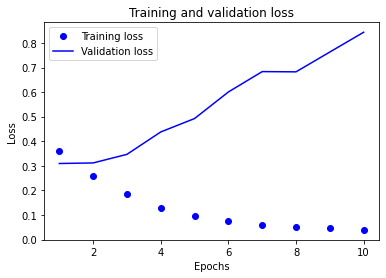

In [ ]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

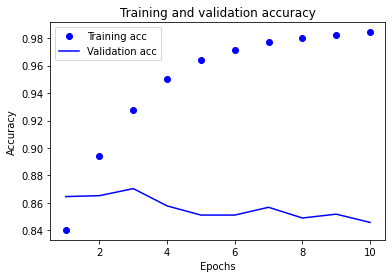

In [ ]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

- 2. LSTM

In [ ]:
# LSTM
vocab_size = 15000
word_vector_dim = 100

model_lstm = tf.keras.Sequential()
model_lstm.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_lstm.add(tf.keras.layers.LSTM(64, return_sequences=True))   
model_lstm.add(tf.keras.layers.Dense(32, activation='relu'))
model_lstm.add(tf.keras.layers.LSTM(64, return_sequences=True))
model_lstm.add(tf.keras.layers.Dense(32, activation='relu'))
model_lstm.add(tf.keras.layers.LSTM(64))
model_lstm.add(tf.keras.layers.Dense(32, activation='relu'))
model_lstm.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.
model_lstm.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_9 (Embedding)     (None, None, 100)         1500000   
                                                                 
 lstm_9 (LSTM)               (None, None, 64)          42240     
                                                                 
 dense_22 (Dense)            (None, None, 32)          2080      
                                                                 
 lstm_10 (LSTM)              (None, None, 64)          24832     
                                                                 
 dense_23 (Dense)            (None, None, 32)          2080      
                                                                 
 lstm_11 (LSTM)              (None, 64)                24832     
                                                                 
 dense_24 (Dense)            (None, 32)              

In [ ]:
model_lstm.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=10  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history_lstm = model_lstm.fit(x_train,
                    y_train,
                    epochs=epochs,
                    batch_size=32,
                    validation_data=(val_x, val_y),
                    verbose=1)

Epoch 1/10
4219/4219 [==============================] - 54s 12ms/step - loss: 0.3609 - accuracy: 0.8377 - val_loss: 0.3231 - val_accuracy: 0.8609
Epoch 2/10
4219/4219 [==============================] - 47s 11ms/step - loss: 0.2726 - accuracy: 0.8851 - val_loss: 0.3095 - val_accuracy: 0.8691
Epoch 3/10
4219/4219 [==============================] - 47s 11ms/step - loss: 0.2263 - accuracy: 0.9070 - val_loss: 0.3246 - val_accuracy: 0.8618
Epoch 4/10
4219/4219 [==============================] - 48s 11ms/step - loss: 0.1858 - accuracy: 0.9253 - val_loss: 0.3490 - val_accuracy: 0.8603
Epoch 5/10
4219/4219 [==============================] - 47s 11ms/step - loss: 0.1511 - accuracy: 0.9416 - val_loss: 0.4082 - val_accuracy: 0.8573
Epoch 6/10
4219/4219 [==============================] - 48s 11ms/step - loss: 0.1223 - accuracy: 0.9537 - val_loss: 0.4686 - val_accuracy: 0.8583
Epoch 7/10
4219/4219 [==============================] - 47s 11ms/step - loss: 0.0999 - accuracy: 0.9622 - val_loss: 0.5323 -

In [ ]:
results = model_lstm.evaluate(x_test,  y_test, verbose=2)

print(results)

1392/1392 - 7s - loss: 0.6494 - accuracy: 0.8395 - 7s/epoch - 5ms/step
[0.649370014667511, 0.8394809365272522]


In [ ]:
history_dict = history_lstm.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


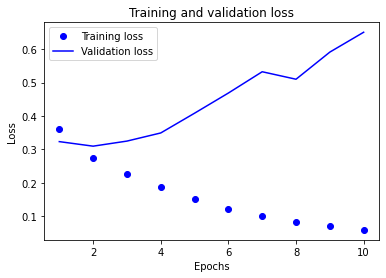

In [ ]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

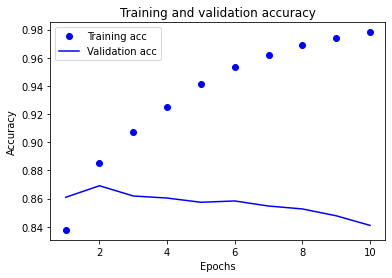

In [ ]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [ ]:
# one GlobalAveragePooling layer
simple = tf.keras.Sequential()
simple.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
simple.add(tf.keras.layers.GlobalAveragePooling1D())
simple.add(tf.keras.layers.Dense(16, activation='relu'))
simple.add(tf.keras.layers.Dense(1, activation='sigmoid'))

simple.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_10 (Embedding)    (None, None, 100)         1500000   
                                                                 
 global_average_pooling1d_2   (None, 100)              0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_26 (Dense)            (None, 16)                1616      
                                                                 
 dense_27 (Dense)            (None, 1)                 17        
                                                                 
Total params: 1,501,633
Trainable params: 1,501,633
Non-trainable params: 0
_________________________________________________________________


In [ ]:
simple.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history_simple = simple.fit(x_train,
                    y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(val_x, val_y),
                    verbose=1)

Epoch 1/10
4219/4219 [==============================] - 17s 4ms/step - loss: 0.3922 - accuracy: 0.8250 - val_loss: 0.3432 - val_accuracy: 0.8495
Epoch 2/10
4219/4219 [==============================] - 16s 4ms/step - loss: 0.3257 - accuracy: 0.8596 - val_loss: 0.3505 - val_accuracy: 0.8452
Epoch 3/10
4219/4219 [==============================] - 17s 4ms/step - loss: 0.3031 - accuracy: 0.8695 - val_loss: 0.3505 - val_accuracy: 0.8482
Epoch 4/10
4219/4219 [==============================] - 16s 4ms/step - loss: 0.2875 - accuracy: 0.8768 - val_loss: 0.3661 - val_accuracy: 0.8434
Epoch 5/10
4219/4219 [==============================] - 15s 4ms/step - loss: 0.2744 - accuracy: 0.8822 - val_loss: 0.3731 - val_accuracy: 0.8447
Epoch 6/10
4219/4219 [==============================] - 17s 4ms/step - loss: 0.2622 - accuracy: 0.8883 - val_loss: 0.3886 - val_accuracy: 0.8435
Epoch 7/10
4219/4219 [==============================] - 15s 4ms/step - loss: 0.2514 - accuracy: 0.8941 - val_loss: 0.4070 - val_ac

In [ ]:
results = simple.evaluate(x_test,  y_test, verbose=2)

print(results)

1392/1392 - 2s - loss: 0.4563 - accuracy: 0.8351 - 2s/epoch - 2ms/step
[0.45630425214767456, 0.83514803647995]


In [ ]:
history_dict = history_simple.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


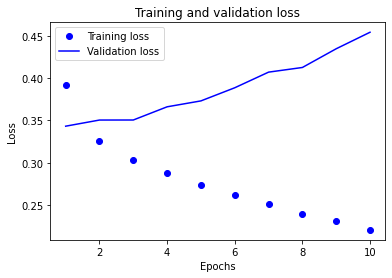

In [ ]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

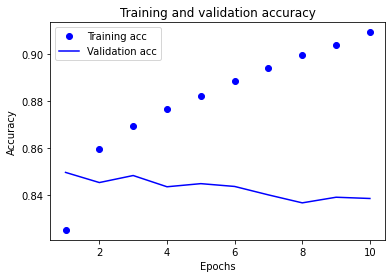

In [ ]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

### 5. 한국어 Word2Vec 임베딩 활용

In [ ]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word2vec_file_path = '/content/drive/MyDrive/AIFFEL/EX/8. 영화리뷰 감상분석/data/word2vec_ko.model'
word_vectors = Word2VecKeyedVectors.load(word2vec_file_path)
vector = word_vectors.wv['끝']

In [ ]:
vector.shape

(100,)

In [ ]:
vocab_size = 15000   
word_vector_dim = 100  # 워드 벡터의 차원수
embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드 벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index2word[i] in word_vectors.wv:
        embedding_matrix[i] = word_vectors.wv[index2word[i]]

In [ ]:

vocab_size = 15000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 100  # 워드 벡터의 차원 수 

# 모델 구성
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model.add(tf.keras.layers.Conv1D(32, 7, activation='relu'))
model.add(tf.keras.layers.MaxPooling1D(5))
model.add(tf.keras.layers.Conv1D(32, 7, activation='relu'))
model.add(tf.keras.layers.GlobalMaxPooling1D())
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid')) 

model.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_11 (Embedding)    (None, 41, 100)           1500000   
                                                                 
 conv1d_5 (Conv1D)           (None, 35, 32)            22432     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 7, 32)            0         
 1D)                                                             
                                                                 
 conv1d_6 (Conv1D)           (None, 1, 32)             7200      
                                                                 
 global_max_pooling1d_4 (Glo  (None, 32)               0         
 balMaxPooling1D)                                                
                                                                 
 dense_28 (Dense)            (None, 16)              

In [ ]:
# 학습의 진행
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              

history = model.fit(x_train,
                    y_train,
                    epochs=3,
                    batch_size=32,
                    validation_data=(val_x, val_y),
                    verbose=1)

Epoch 1/10
4219/4219 [==============================] - 22s 5ms/step - loss: 0.4484 - accuracy: 0.7862 - val_loss: 0.3683 - val_accuracy: 0.8340
Epoch 2/10
4219/4219 [==============================] - 19s 5ms/step - loss: 0.3361 - accuracy: 0.8536 - val_loss: 0.3383 - val_accuracy: 0.8466
Epoch 3/10
4219/4219 [==============================] - 19s 5ms/step - loss: 0.2951 - accuracy: 0.8750 - val_loss: 0.3278 - val_accuracy: 0.8590
Epoch 4/10
4219/4219 [==============================] - 20s 5ms/step - loss: 0.2656 - accuracy: 0.8896 - val_loss: 0.3294 - val_accuracy: 0.8576
Epoch 5/10
4219/4219 [==============================] - 20s 5ms/step - loss: 0.2414 - accuracy: 0.9013 - val_loss: 0.3424 - val_accuracy: 0.8555
Epoch 6/10
4219/4219 [==============================] - 19s 5ms/step - loss: 0.2174 - accuracy: 0.9125 - val_loss: 0.3586 - val_accuracy: 0.8559
Epoch 7/10
4219/4219 [==============================] - 20s 5ms/step - loss: 0.1959 - accuracy: 0.9233 - val_loss: 0.3730 - val_ac

In [ ]:
# 테스트셋을 통한 모델 평가
results = model.evaluate(x_test,  y_test, verbose=2)

print(results)

1392/1392 - 3s - loss: 0.4851 - accuracy: 0.8457 - 3s/epoch - 2ms/step
[0.48513779044151306, 0.8456771969795227]


In [ ]:
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


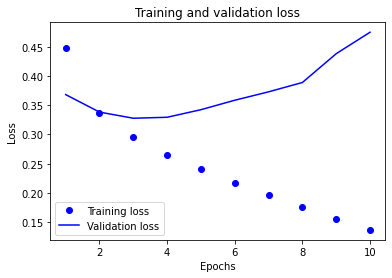

In [ ]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

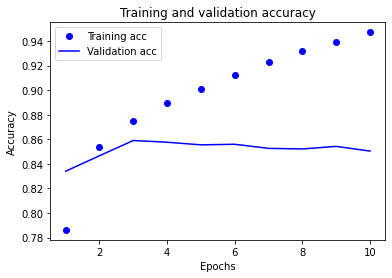

In [ ]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()